# analyse de marée, cas synthétique

On fait l'hypothèse que le signal est la somme d'un bruit et de signaux aux fréquences harmoniques de marée:
$$
\begin{align}
y_i = b_0 + \sum_c \beta_c \cos \big ( \omega_c t_i - \phi_c \big) + e_i
\end{align}
$$
où $c$ désigne le constituent de marée (M2, S2, O1, K1, etc ...), $b_0$ est ...

Les inconnues recherchées sont $\beta_c$ et les $\phi_c$.
On résout le problème grâce une méthode des moindres carrés.
Il faut amener l'équation sous la bonne forme:
$$
\begin{align}
y_i &= b_0 + \sum_c \beta_c \cos \phi_c \cos \omega_c t_i 
+ \beta_c \sin \phi_c \sin \omega_c t_i 
+ e_i \\
&= b_0 + \sum_c a_c \cos \omega_c t_i 
+ b_c \sin \omega_c t_i 
+ e_i 
\end{align}
$$


$$
\begin{align}
y_i &= b_0 + \sum_c \beta_c \cos \phi_c \cos \omega_c t_i 
+ \beta_c \sin \phi_c \sin \omega_c t_i 
+ e_i \\
&= b_0 + \sum_c a_c \cos \omega_c t_i 
+ b_c \sin \omega_c t_i 
+ e_i 
\end{align}
$$

Il s'agit donc maintenant de résoudre le problème matriciel suivant:
$$
\begin{align}
\mathbf{Y} = \mathbf{X} \mathbf{B}
\end{align}
$$
où les matrices $\mathbf{Y},\mathbf{X},\mathbf{B}$ sont données par:
...


La solution minimisant la norme au carré des erreurs est donnée par:
$$
\begin{align}
\mathbf{B} = (\mathbf{X}'\mathbf{X})^{-1} \mathbf{X}' \mathbf{Y}
\end{align}
$$



Documentation:
    
- [xarray](http://xarray.pydata.org/en/stable/index.html)

- [normal distributions](https://en.wikipedia.org/wiki/Normal_distribution)

- recherche sur google

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## génère des données synthétiques

In [2]:
t = pd.date_range('2000-01-01', freq='H', periods=365 * 24)
time = xr.DataArray((t-t[0])/pd.Timedelta('1D'), \
                    dims=['time']).rename('time')
constituents = xr.DataArray(['M2','S2'],dims=['constituents']) #.rename('constituents')
omega = xr.DataArray([1.9322,2.], dims=['constituents'], coords={'constituents': constituents})

# vrais amplitude, phase
beta = (xr.DataArray([1.,.5], dims=['constituents'], 
                    coords={'constituents': constituents})
        .rename('beta'))
phi = (xr.DataArray([0.,0.], dims=['constituents'], 
                  coords={'constituents': constituents}).rename('phi'))

y_tide = beta*np.cos(2.*np.pi*omega*time+phi)

In [3]:
y_tide

<xarray.DataArray (constituents: 2, time: 8760)>
array([[1.000000e+00, 8.747635e-01, 5.304224e-01, ..., 9.974020e-01,
        8.375853e-01, 4.679761e-01],
       [5.000000e-01, 4.330127e-01, 2.500000e-01, ..., 5.666491e-15,
        2.500000e-01, 4.330127e-01]])
Coordinates:
  * constituents  (constituents) <U2 'M2' 'S2'
  * time          (time) float64 0.0 0.04167 0.08333 0.125 ... 364.9 364.9 365.0

### illustration du signal de marée, cycle vive eau/ morte eau

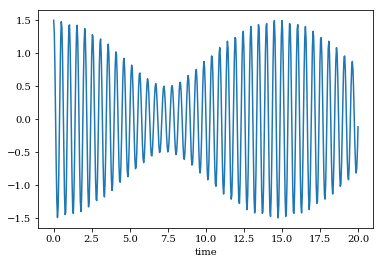

In [4]:
y_tide.sum('constituents').sel(time=slice(0,20)).plot()

## generation du bruit

In [5]:
noise_level = 1.
N_realisations = 100
noise = (xr.DataArray(noise_level*np.random.randn(time.size, N_realisations), 
                      coords={'time':time},
                      dims=['time','realisation'])
        )

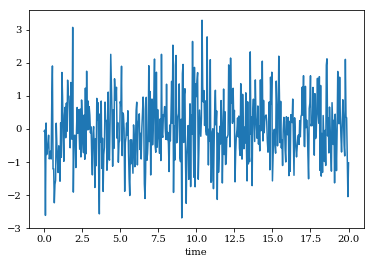

In [6]:
noise.isel(realisation=0).sel(time=slice(0,20)).plot()

In [7]:
help(np.random.randn)

Help on built-in function randn:

randn(...) method of mtrand.RandomState instance
    randn(d0, d1, ..., dn)
    
    Return a sample (or samples) from the "standard normal" distribution.
    
    If positive, int_like or int-convertible arguments are provided,
    `randn` generates an array of shape ``(d0, d1, ..., dn)``, filled
    with random floats sampled from a univariate "normal" (Gaussian)
    distribution of mean 0 and variance 1 (if any of the :math:`d_i` are
    floats, they are first converted to integers by truncation). A single
    float randomly sampled from the distribution is returned if no
    argument is provided.
    
    This is a convenience function.  If you want an interface that takes a
    tuple as the first argument, use `numpy.random.standard_normal` instead.
    
    Parameters
    ----------
    d0, d1, ..., dn : int, optional
        The dimensions of the returned array, should be all positive.
        If no argument is given a single Python float is ret

In [8]:
Y = y_tide.sum('constituents') + noise
Y

<xarray.DataArray (time: 8760, realisation: 100)>
array([[ 1.420999,  0.060582,  0.695762, ...,  2.467492,  2.940854,  0.143565],
       [ 1.263544,  2.151893,  1.612822, ...,  0.385665,  1.093051,  2.679812],
       [-1.844603,  0.196743,  0.23351 , ..., -1.415968, -0.080197,  2.146537],
       ...,
       [ 1.333982,  0.597024,  1.5443  , ...,  0.331906, -0.158304, -0.918863],
       [ 1.87638 ,  0.890764,  0.292633, ...,  1.275258,  0.988499,  0.82791 ],
       [ 2.364071, -0.736052,  0.276075, ...,  1.802583,  2.326479,  0.38445 ]])
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 364.9 364.9 365.0
Dimensions without coordinates: realisation

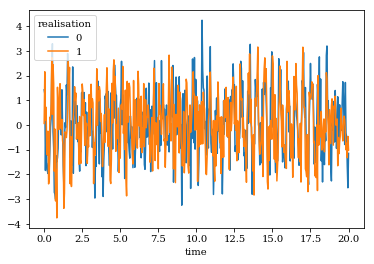

In [9]:
Y.isel(realisation=slice(0,2)).sel(time=slice(0,20)).plot.line(x='time')

In [10]:
X = np.hstack((np.ones((time.size,1)), 
               np.cos(2.*np.pi*omega*time).values.T, 
               np.sin(2.*np.pi*omega*time).values.T))

In [11]:
def get_solution(X, Y):
    B = np.linalg.lstsq(X,Y.values)[0]
    Nc = int((B.shape[0]-1)/2)
    ds = xr.Dataset({'b0': (['realisations'], B[0,:]),
                     'a': (['realisations','constituents'], B[1:Nc+1,:].T),
                     'b': (['realisations','constituents'], B[Nc+1:,:].T)}, 
                     coords={'constituents': constituents})
    return ds

ds = get_solution(X,Y)
ds

/home1/homedir5/perso/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


<xarray.Dataset>
Dimensions:       (constituents: 2, realisations: 100)
Coordinates:
  * constituents  (constituents) <U2 'M2' 'S2'
Dimensions without coordinates: realisations
Data variables:
    b0            (realisations) float64 -0.01669 0.01194 ... 0.02064 0.001943
    a             (realisations, constituents) float64 0.9748 0.4871 ... 0.495
    b             (realisations, constituents) float64 0.00736 ... 0.002025

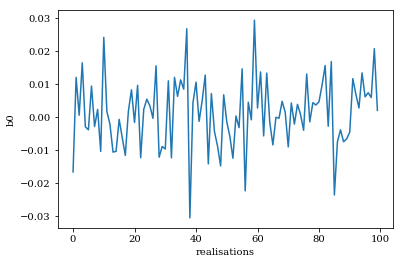

In [12]:
ds.b0.plot()

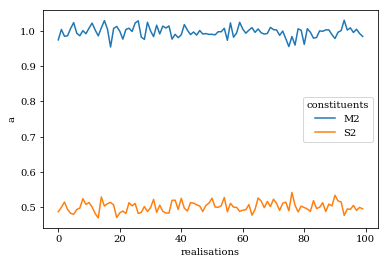

In [13]:
ds.a.plot.line(x='realisations')

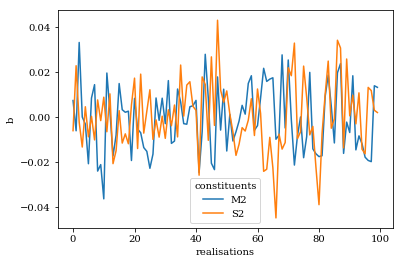

In [14]:
ds.b.plot.line(x='realisations')